In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import Birch

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image as tf_image
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
%matplotlib inline

## Imagen Original

Tamaño original :  (4032, 3024, 3)
Tamaño reducido :  (2016, 1512, 3)


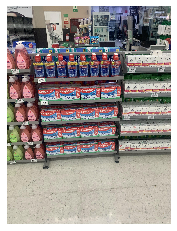

In [2]:
PATH = "../../data/JPEG/" 
image = cv2.imread(PATH+'IMG_2492.jpg')
print('Tamaño original : ', image.shape)
 
scale_percent = 50 
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)

resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
 
print('Tamaño reducido : ',resized_image.shape)
 
plt.axis("off")
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.show()

# Selección del objeto de interés

In [3]:
def rotate_image(image, angle):
  """
  Función rotar imagen

  Args:
  image
  angle

  Return:
  rotated_image
  """
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

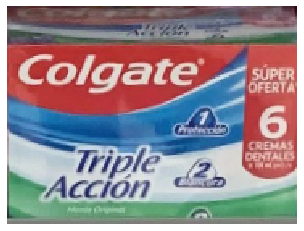

In [4]:
cropped = rotate_image(resized_image, -2)[int(1475*scale_percent/100):int(1745*scale_percent/100), 
                                        int(1370*scale_percent/100):int(1730*scale_percent/100)]

plt.axis("off")
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.show()

# Detector Inceptionv3

In [5]:
# Carga la red neuronal Inceptionv3
base_model = InceptionV3(weights='imagenet', include_top=False)

def Inceptionv3_feature(img):
    """
    Obtiene las características de la imagen de acuerdo a Inceptionv3

    Args:
    img

    Return:
    feature_vector
    """
    img = tf.image.resize(img, (224, 224))
    x = tf_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return base_model.predict(x)

def Inceptionv3_similarity(image_1, image_2):
    """
    Calcula la similaridad del coseno entre 2 imagenes

    Args:
    image_1
    image_2

    Return:
    cosine_similarity
    """
    I1_vector = Inceptionv3_feature(image_1)
    I2_vector = Inceptionv3_feature(image_2)
    return cosine_similarity(I1_vector.reshape(1,-1), I2_vector.reshape(1,-1))

# Detección y conteo de los objetos de interés

In [6]:
image_template = cropped
input_image = resized_image

In [7]:
height, width = image_template.shape[:2]
prob_width, prob_height = int(width*1.5), int(height*1.5)

In [8]:
x_detect=[]
y_detect=[]
score = []
threshold = 0.8
counter = 0

for y in range(0, input_image.shape[0]-height, int(min(image_template.shape[:2])/2)):
    for x in range(0, input_image.shape[1]-width, int(min(image_template.shape[:2])/2)):
        temp_img = input_image[y:y+height, x:x+width]        
        matches = Inceptionv3_similarity(image_template, temp_img)
        if matches >= threshold:
            x_detect.append(x)
            y_detect.append(y)
            score.append(matches)
            counter += 1

## Clusterización

In [9]:
lista = np.array(list(zip(x_detect, y_detect)))
clustering = Birch(threshold=min(image_template.shape[:2])*0.4 , n_clusters=None).fit(lista)

In [10]:
centroids = []
for each in np.unique(clustering.labels_):
    centroids.append(lista[clustering.labels_ == each].sum(axis=0)/len(lista[clustering.labels_ == each]))

In [11]:
for x, y in centroids:
    x = int(x)
    y = int(y)
    cv2.rectangle(input_image, (x, y), (x+width, y+height), (0,255,0), 3)

# Resultados

El número de objetos detectados antes de la clusterización es :  18
El número de objetos detectados es :  13


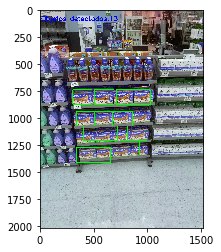

In [12]:
print(f'El número de objetos detectados antes de la clusterización es : ', str(counter))
print(f'El número de objetos detectados es : ', str(len(centroids)))

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(input_image,'Objetos detectados:'+str(len(centroids)),(10,100), font, 2,(0,0,255),6)

plt.imshow(input_image)
plt.show()

cv2.imwrite('Inceptionv3_DETECTION.jpg', input_image);